# Weighted Portfolio (prettier graphs)

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbols = ['SPY', 'TLT', 'GLD']
weights = {'SPY': 0.50, 'TLT': 0.40, 'GLD': 0.10}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,SPY_high,SPY_low,SPY_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close
date,,,,,,,,,
1993-01-29,26.32,26.19,26.30,nan,nan,nan,nan,nan,nan
1993-02-01,26.49,26.32,26.49,nan,nan,nan,nan,nan,nan
1993-02-02,26.56,26.41,26.54,nan,nan,nan,nan,nan,nan
1993-02-03,26.84,26.56,26.82,nan,nan,nan,nan,nan,nan
1993-02-04,26.99,26.62,26.94,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...
2020-06-08,323.41,319.63,323.20,156.85,155.05,156.71,159.86,158.47,159.72
2020-06-09,323.28,319.36,320.79,159.64,158.30,158.49,161.78,160.87,161.26
2020-06-10,322.39,318.22,319.00,160.90,159.05,160.84,163.63,160.52,163.57


In [5]:
# add calendar columns
ts = pf.calendar(ts)

In [6]:
ts, start = pf.finalize_timeseries(ts, start)

In [7]:
tlogs = portfolio.init_trade_logs(ts, capital)
tlogs

SPY    <pinkfish.trade.TradeLog object at 0x7efee3009...
TLT    <pinkfish.trade.TradeLog object at 0x7efee3601...
GLD    <pinkfish.trade.TradeLog object at 0x7efee3601...
dtype: object

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = True if (i == len(ts) - 1) else False

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio._symbols:
            price = getattr(row, symbol + '_close')
            weight = 0 if end_flag else weights[symbol]
            tlog = tlogs[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, tlog, row)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs(tlogs)

In [10]:
rlog.head()

,date,price,shares,entry_exit,symbol
0,2004-12-01,87.33,57,entry,SPY
1,2004-12-01,51.53,77,entry,TLT
2,2004-12-01,45.38,22,entry,GLD
3,2005-01-03,43.02,1,entry,GLD
4,2005-01-03,53.09,1,exit,TLT


In [11]:
tlog.head()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,symbol
0,2004-12-01,51.53,2005-01-03,53.09,1.57,1.57,1,1.57,TLT
1,2004-12-01,51.53,2005-02-01,54.78,3.26,6.51,2,8.08,TLT
2,2004-12-01,45.38,2005-03-01,43.22,-2.16,-2.16,1,5.92,GLD
3,2004-12-01,51.53,2005-04-01,54.00,2.47,2.47,1,8.39,TLT
4,2004-12-01,51.53,2005-05-02,55.89,4.36,4.36,1,12.75,TLT


In [12]:
dbal.head()

,high,low,close,shares,cash,state
date,,,,,,
2004-11-18,10000.00,10000.00,10000.00,0,10000.00,-
2004-11-19,10000.00,10000.00,10000.00,0,10000.00,-
2004-11-22,10000.00,10000.00,10000.00,0,10000.00,-
2004-11-23,10000.00,10000.00,10000.00,0,10000.00,-
2004-11-24,10000.00,10000.00,10000.00,0,10000.00,-


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2004-11-18
end                                                     2020-06-12
beginning_balance                                            10000
ending_balance                                            37248.35
total_net_profit                                          26204.63
gross_profit                                              27809.82
gross_loss                                                 -561.46
profit_factor                                                49.53
return_on_initial_capital                                   262.05
annual_return_rate                                            8.82
trading_period                           15 years 6 months 25 days
pct_time_in_market                                           99.80
total_num_trades                                               345
trades_per_year                                              22.16
num_winning_trades                                            

In [14]:
benchmark = pf.Benchmark(symbol='SPY', capital=capital, start=start, end=end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  114 SPY @ 86.97
2020-06-12 00:00:00 SELL 114 SPY @ 304.21


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

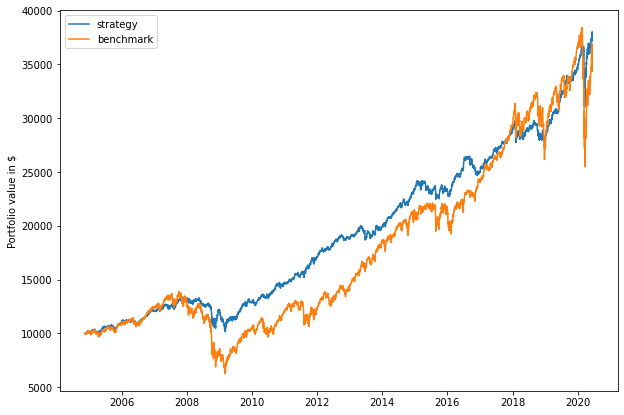

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

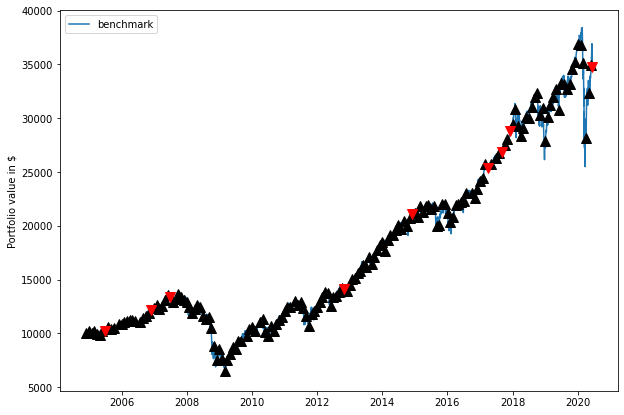

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary5(stats, benchmark.stats)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$37,248.35","$34,764.83"
total_net_profit,"$26,204.63","$24,764.83"
gross_profit,"$27,809.82","$24,764.83"
gross_loss,-$561.46,$0.00


,strategy,benchmark
annual_return_rate,8.82,8.33
max_closed_out_drawdown,-24.04,-54.85
drawdown_annualized_return,-2.73,-6.58
drawdown_recovery,-1.26,-1.42
best_month,16.78,23.30
worst_month,-15.40,-30.92
sharpe_ratio,1.00,0.51
sortino_ratio,1.31,0.60
monthly_std,2.36,4.56
trades_per_year,22.16,0.06


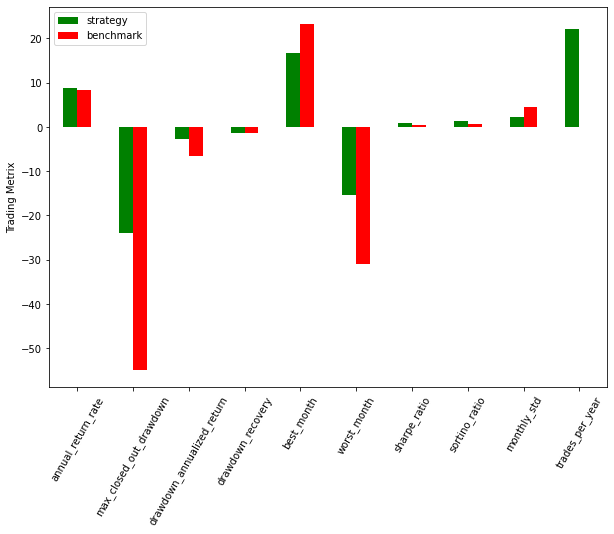

In [20]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std',
           'trades_per_year')

df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df

In [21]:
returns = dbal['close']
returns.tail()

date
2020-06-08   37828.66
2020-06-09   37879.29
2020-06-10   38037.12
2020-06-11   37169.05
2020-06-12   37248.35
Name: close, dtype: float64

In [22]:
benchmark_returns = benchmark.dbal['close']
benchmark_returns.tail()

date
2020-06-08   36929.69
2020-06-09   36654.95
2020-06-10   36450.89
2020-06-11   34354.43
2020-06-12   34764.83
Name: close, dtype: float64

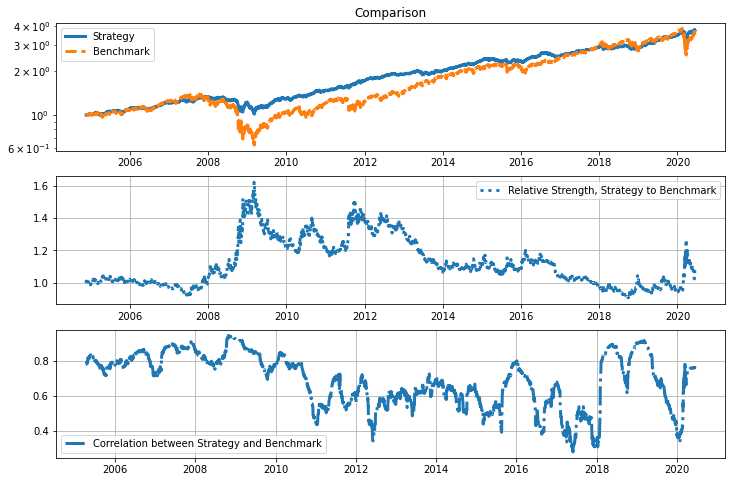

In [23]:
pf.prettier_graphs(returns, benchmark_returns, label1='Strategy', label2='Benchmark', points_to_plot=5000)